# LSTM + CNN model on real life time series

* Experiments with the effect of an addtional Convolutional layer on LSTM model performance on forecasting real life time series.
* Real life time series of sunspot intensity
* Windowed time siries for training.
* Dynamic tuning of learning rate with callbacks.
* Lambda layers for post-processing of data within NN.

## Download the sunspot data

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-05-16 15:59:39--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.6.16
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.6.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.08s   

2020-05-16 15:59:39 (896 KB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



In [3]:
# Importing data as time sires
import numpy as np
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    # Skip the header
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
print("Length of the data set = ", len(time))

Length of the data set =  3235


* Helper function for plotting time sires
* As it can be seen, the sunspot event has some seanonality, but the it is not that periodic as the synthesized time sires.

In [4]:
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time (months)",fontsize=20)
    plt.ylabel("Sunspot Intensity",fontsize=20)
    ax = plt.gca()
    ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
    plt.grid(True)

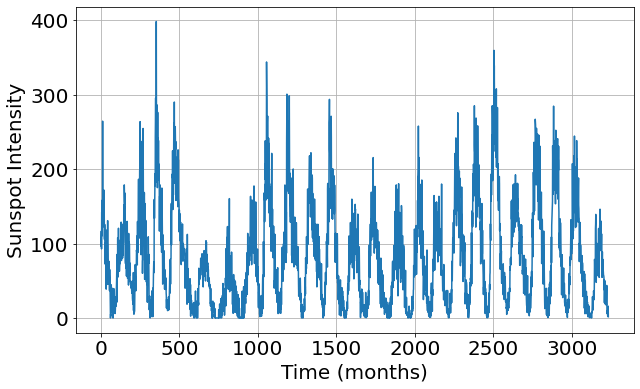

In [5]:
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.savefig("/Users/johanzhuohan/Downloads/Sunspot.png")
plt.show()

* Split the data into training and testing dataset.

In [5]:
split_time = 2560
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
print("Length of training data set = ", str(len(time_train)))
print("Length of testing data set = ", str(len(time_valid)))

Length of training data set =  2560
Length of testing data set =  675


## Windowed time series

* Time windows generator (with tf.data.Dataset) for creating input datasets for training neural network.

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # Expand the dimension of time sires, in order to feed into the NN
    series = tf.expand_dims(series, axis=-1)
    # Create tensorflow dataset from time serie array
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # Create windowed (nested) dataset, "+ 1" for the label data
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    # Flattening out the windowed dataset with a given window size
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    # Shuffling the dataset & separating dataset into inputs and labels
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1:]))
    # Batch the input-label dataset with a given batch size
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

* Helper function for model prediction.

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

## LSTM alone

* Here, we use LSTM without convolutional layer.

In [8]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


* The periodicity is about 132 months (11 years). I set the window size to 60, which is about the half of the periodicity.

In [9]:
# Create input dataset with training dataset
window_size = 64
batch_size = 32
shuffle_buffer_size = 1000
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>


* First check the optimal learning rate with dynamic adjustment of lr using call backs
* Lambda layers are used to post-processing of the data
* Hubber loss function is used instead of mse. Hubber loss function is less sensitive to the large noise.

In [10]:
tf.random.set_seed(51)

model1 = tf.keras.models.Sequential([
    # 2 LSTM layers
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=[None,1]),
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Dense layers
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    # Output layer
    tf.keras.layers.Dense(1),
    # Rescale the results
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# SGD optimizer with an initial learning rate
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

# Huber loss function which is less sensitive to the largely fluctuated noise than mse
model1.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 64)          16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          12416     
_________________________________________________________________
dense (Dense)                (None, None, 20)          660       
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          210       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 30,193
Trainable params: 30,193
Non-trainable params: 0
____________________________________________________

* Dynamic tuning of learning rate with callbacks is used to choose an appropriate learning rate for training this LSTM model.

In [11]:
# Construct learning rate scheduler based on the number of epoch
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

# Training
history1 = model1.fit(dataset,epochs=100,callbacks=[lr_schedule], verbose=1)

Epoch 1/100


W1216 20:11:40.040225 140734800741824 deprecation.py:323] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


78/78 [==============================] - 9s 111ms/step - loss: 78.0680 - mae: 78.5649

* Plotting the loss function as a function of learning rate
* Optimal learning rate < $10^{-5}$

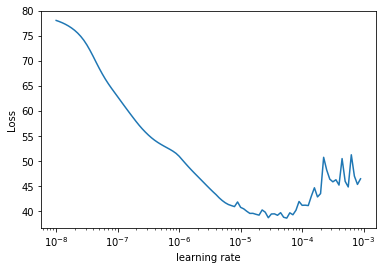

In [12]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history1.history["loss"])
#plt.axis([1e-8, 1e-3, 0, 30])
plt.xlabel("learning rate")
plt.ylabel("Loss")
plt.show()

* Retraining the model with an appropriate learning rate

In [13]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True,input_shape=[None,1]),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Optimizer with an appropriate learning rate
optimizer = tf.keras.optimizers.SGD(lr=5e-6, momentum=0.9)

model2.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

history2 = model2.fit(dataset,epochs=400, verbose=0)

* Plotting the training history
* The loss reduces smoothly during the training.

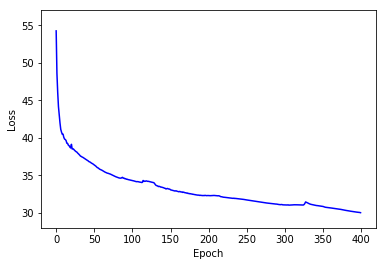

In [14]:
loss = history2.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim([28,57])
plt.show()

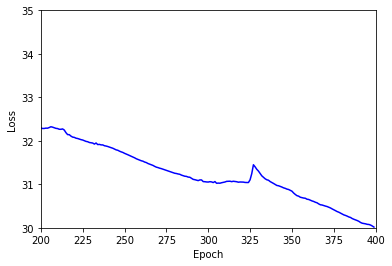

In [15]:
loss = history2.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xlim([200,400])
plt.ylim([30,35])
plt.show()

* Plotting the prediction with LSTM model
* Prediction from LSTM model looks great, but the MAE is as high as ~22.

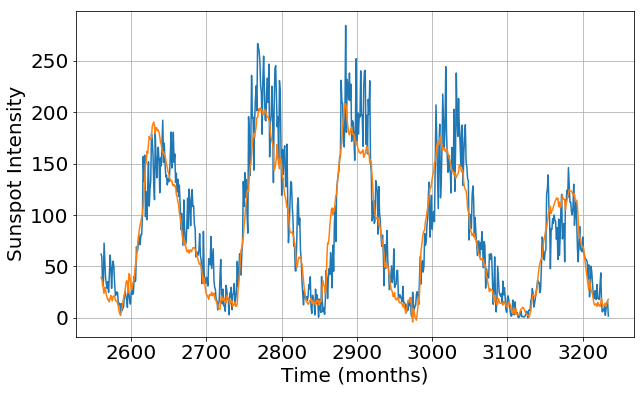

In [37]:
rnn_forecast1 = model_forecast(model2, series[..., np.newaxis], window_size)
rnn_forecast1 = rnn_forecast1[split_time - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast1)
plt.show()

* Mean squre error and mean absolute error of the simple LSTM model

In [17]:
print("Simple LSTM MSE = ", tf.keras.metrics.mean_squared_error(x_valid, rnn_forecast1).numpy())
print("Simple LSTM MAE = ", tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast1).numpy())

Simple LSTM MSE =  767.0881
Simple LSTM MAE =  20.295212


## LSTM + CNN

* Here, we use LSTM with an additional convolutional layer.
* Casual padding is used : output[t] is not affected by input[t-1:]

* First check the optimal learning rate with dynamic adjustment of lr using call backs
* Lambda layers are used to post-processing of the data
* Hubber loss function is used instead of mse. Hubber loss function is less sensitive to the large noise.

In [18]:
tf.random.set_seed(51)

model3 = tf.keras.models.Sequential([
    # 1D convolutional layers for extracting preliminary features
    # Casual padding: output[t] is not affected by input[t-1:]
    tf.keras.layers.Conv1D(filters=30, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    # 2 LSTM layers
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Dense layers
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    # Output layer
    tf.keras.layers.Dense(1),
    # Rescale the results
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# SGD optimizer with an initial learning rate
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

# Huber loss function which is less sensitive to the largely fluctuated noise than mse
model3.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 30)          180       
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 64)          24320     
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 32)          12416     
_________________________________________________________________
dense_6 (Dense)              (None, None, 20)          660       
_________________________________________________________________
dense_7 (Dense)              (None, None, 10)          210       
_________________________________________________________________
dense_8 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda_2 (Lambda)            (None, None, 1)          

* Dynamic tuning of learning rate with callbacks is used to choose an appropriate learning rate for training this LSTM model.

In [19]:
# Construct learning rate scheduler based on the number of epoch
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

# Training
history3 = model3.fit(dataset,epochs=100,callbacks=[lr_schedule], verbose=1)

Epoch 1/100
78/78 [==============================] - 9s 114ms/step - loss: 146.7350 - mae: 147.2350

* Plotting the loss function as a function of learning rate
* Optimal learning rate < $10^{-4}$

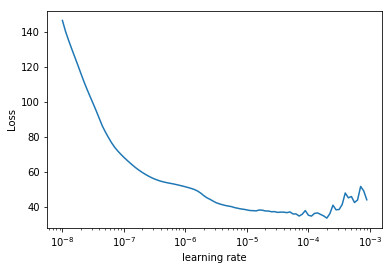

In [20]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history3.history["loss"])
#plt.axis([1e-8, 1e-3, 0, 30])
plt.xlabel("learning rate")
plt.ylabel("Loss")
plt.show()

* Retraining the model with an appropriate learning rate

In [31]:
model4 = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=30, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True,input_shape=[None,1]),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Optimizer with an appropriate learning rate
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

model4.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

history4 = model4.fit(dataset,epochs=400, verbose=0)

* Plotting the training history
* LSTM + CNN can reach lower training loss with the same number of epochs.

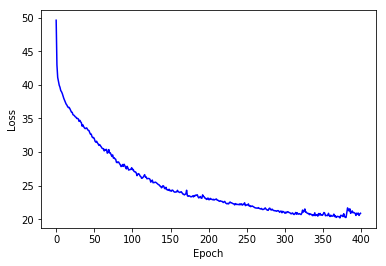

In [32]:
loss = history4.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.ylim([2,10])
plt.show()

* The fluctuation in training loss during the training is much larger than pure LSTM model.

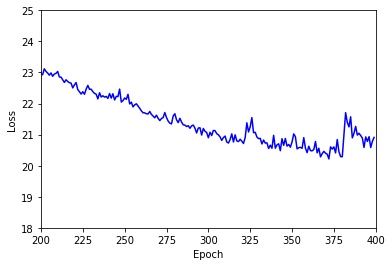

In [33]:
loss = history4.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xlim([200,400])
plt.ylim([18,25])
plt.show()

* Plotting the prediction with LSTM + CNN model

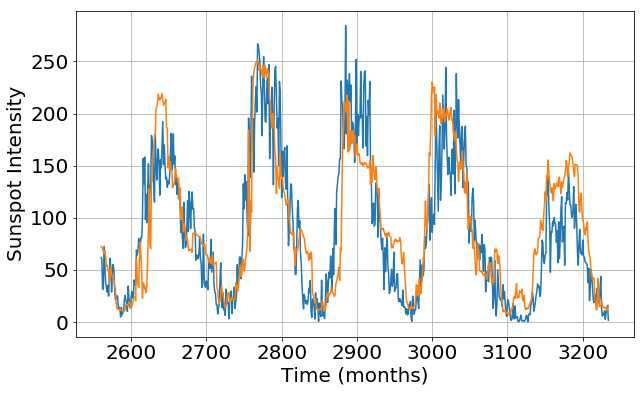

In [38]:
rnn_forecast2 = model_forecast(model4, series[..., np.newaxis], window_size)
rnn_forecast2 = rnn_forecast2[split_time - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast2)
plt.show()

* Mean squre error and mean absolute error
* Although this model reached a lower training loss than pure LSTM model, the validation loss is higher now, indicating the overfitting.

In [35]:
print("LSTM+CNN MSE = ", tf.keras.metrics.mean_squared_error(x_valid, rnn_forecast2).numpy())
print("LSTM+CNN MAE = ", tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast2).numpy())

LSTM+CNN MSE =  1527.9175
LSTM+CNN MAE =  29.41389
